In [203]:
import numpy as np
from scipy.linalg import norm
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector

# Exercise
We have seen how to time evolve an Ising Hamiltonian. In this exercise we ask you to time-evolve a Heisenberg Hamiltonian with transverse field,
$$ H = J \sum_i X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1} + h \sum_i X_i$$
for $N=4$ sites with $J = 1, h = 0.5$, periodic boundary conditions (PBC).
1. Modify the `get_H_op` function suitably to print out all the Pauli terms of the hamiltonian.
    - How many are there for a 4 site model with periodic boundary conditions (PBC).
2. Implement a method `heisenberg_trotter_circ` to obtain the circuit for Trotter evolution. (This should be the equivalent function to `ising_trotter_circ` from the tutorial.)
    - Print the Trotter circuit for 1 Trotter step with a steps size of $\delta t = 0.25$.
3. Compare the exact time evolution with your Trotter implementation up to $t = 10$ with a Trotter time step of $\delta t = 0.1$
    - compute the same observables as in the tutorial; the average magnetization $M_z = \frac{1}{N} \sum_i Z_i$ and the initial state revival $|\langle \psi_{\rm init} | \psi(t) \rangle|^2$.
    - plot both quantities as a function of time for both the exact and the Trotter evolution
    - print the final value (at time $t = 10$) of magnetization and initial state revival for exact and Trotter evolution.

# Solution
### 1. Modify the `get_H_op` function suitably to print out all the Pauli terms of the hamiltonian.
- How many are there for a 4 site model with periodic boundary conditions (PBC)?

In [217]:
def get_H_op(N, Jx, Jy, Jz, h, pbc):
    """Define the non-commuting parts of the Hamiltonian separately."""
    
    xx_op_strings = []
    yy_op_strings = []
    zz_op_strings = []
    for i in range(N - 1):
        xx_op_strings.append((N - 2 - i)*"I" + "X" + "X" + i*"I")
        yy_op_strings.append((N - 2 - i)*"I" + "Y" + "Y" + i*"I")
        zz_op_strings.append((N - 2 - i)*"I" + "Z" + "Z" + i*"I")

    # last term for periodic BC
    if pbc and N > 2:
        xx_op_strings.append("X" + (N - 2)*"I" + "X")
        yy_op_strings.append("Y" + (N - 2)*"I" + "Y")
        zz_op_strings.append("Z" + (N - 2)*"I" + "Z")

    x_op_strings = []
    for i in range(N):
        x_op_strings.append(((N - 1 - i)*"I" + "X" + i*"I"))

    xx_ops = SparsePauliOp(data=xx_op_strings, coeffs=[Jx] * (N if (pbc and N > 2) else N - 1))
    yy_ops = SparsePauliOp(data=yy_op_strings, coeffs=[Jy] * (N if (pbc and N > 2) else N - 1))
    zz_ops = SparsePauliOp(data=zz_op_strings, coeffs=[Jz] * (N if (pbc and N > 2) else N - 1))
    x_ops = SparsePauliOp(data=x_op_strings, coeffs=[h] * N)
    
    return xx_ops, yy_ops, zz_ops, x_ops

In [205]:
# define basic parameters
N = 4
Jx, Jy, Jz = 1, 1, 1
h = 0.5
pbc = True

In [206]:
xx_ops, yy_ops, zz_ops, x_ops = get_H_op(N, Jx, Jy, Jz, h, pbc)
H_op = xx_ops + yy_ops + zz_ops + x_ops
                    
print(f"H_xx =\n{xx_ops}")
print(f"H_yy =\n{yy_ops}")
print(f"H_zz =\n{zz_ops}")
print(f"H_x =\n{x_ops}")

print(f"H_heisenberg =\n{H_op}")
print(f"\n *** The Hamiltonian contains {len(H_op)} terms")

H_xx =
SparsePauliOp(['IIXX', 'IXXI', 'XXII', 'XIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
H_yy =
SparsePauliOp(['IIYY', 'IYYI', 'YYII', 'YIIY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
H_zz =
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'ZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
H_x =
SparsePauliOp(['IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
H_heisenberg =
SparsePauliOp(['IIXX', 'IXXI', 'XXII', 'XIIX', 'IIYY', 'IYYI', 'YYII', 'YIIY', 'IIZZ', 'IZZI', 'ZZII', 'ZIIZ', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])

 *** The Hamiltonian contains 16 terms


### 2. Implement a method `heisenberg_trotter_circ` to obtain the circuit for Trotter evolution.
- Print the Trotter circuit for 1 Trotter step with a steps size of $\delta t = 0.25$.


In [218]:
def heisenberg_trotter_circ(H_list, N, t_final, dt, init_circ=None):
    """This method implements a Trotter circuit for the time evolution of the transverse field Ising model."""
    Nt = int(np.round(t_final / dt))

    num_terms = len(H_list[0])

    x_ops = H_list[0]
    xx_ops = H_list[1]
    yy_ops = H_list[2]
    zz_ops = H_list[3]

    x_circ = QuantumCircuit(N)
    xx_circ = QuantumCircuit(N)
    yy_circ = QuantumCircuit(N)
    zz_circ = QuantumCircuit(N)

    for i in range(num_terms):
        # indices of qubits acted on by Rzz gate, keeping in mind periodic boundaty conditions
        if not i == N - 1:
            n, m = i, i + 1
        else:
            n, m = N - 1, 0

        # R_xx(t) etc. implements exp(-i t ZZ / 2 ), so need to account for the factor of 2
        x_circ.rx(2 * float(x_ops.coeffs[i]) * dt, i)
        xx_circ.rxx(2 * float(xx_ops.coeffs[i]) * dt, n, m)
        yy_circ.ryy(2 * float(yy_ops.coeffs[i]) * dt, n, m)
        zz_circ.rzz(2 * float(zz_ops.coeffs[i]) * dt, n, m)

    qreg = QuantumRegister(N)
    evo_circ = QuantumCircuit(qreg)
    if init_circ is not None:
        evo_circ.append(init_circ, qreg)
    for _ in range(Nt):
        evo_circ.append(x_circ, qreg)
        evo_circ.barrier()
        evo_circ.append(xx_circ, qreg)
        evo_circ.barrier()
        evo_circ.append(yy_circ, qreg)
        evo_circ.barrier()
        evo_circ.append(zz_circ, qreg)
        evo_circ.barrier()
        evo_circ.barrier()
        
    return evo_circ



In [219]:
circ = heisenberg_trotter_circ([x_ops, xx_ops, yy_ops, zz_ops], N, 0.25, 0.25)
circ.decompose().draw()

/var/folders/gz/ps5ykb1d4n177p_y32sx3slh0000gn/T/ipykernel_11055/1727880853.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  x_circ.rx(2 * float(x_ops.coeffs[i]) * dt, i)
/var/folders/gz/ps5ykb1d4n177p_y32sx3slh0000gn/T/ipykernel_11055/1727880853.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  xx_circ.rxx(2 * float(xx_ops.coeffs[i]) * dt, n, m)
/var/folders/gz/ps5ykb1d4n177p_y32sx3slh0000gn/T/ipykernel_11055/1727880853.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  yy_circ.ryy(2 * float(yy_ops.coeffs[i]) * dt, n, m)
/var/folders/gz/ps5ykb1d4n177p_y32sx3slh0000gn/T/ipykernel_11055/1727880853.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  zz_circ.rzz(2 * float(zz_ops.coeffs[i]) * dt, n, m)


┌──────────┐ ░ ┌───────────┐                          ┌───────────┐ ░ »
q2397_0: ┤ Rx(0.25) ├─░─┤0          ├──────────────────────────┤1          ├─░─»
         ├──────────┤ ░ │  Rxx(0.5) │┌───────────┐             │           │ ░ »
q2397_1: ┤ Rx(0.25) ├─░─┤1          ├┤0          ├─────────────┤           ├─░─»
         ├──────────┤ ░ └───────────┘│  Rxx(0.5) │┌───────────┐│  Rxx(0.5) │ ░ »
q2397_2: ┤ Rx(0.25) ├─░──────────────┤1          ├┤0          ├┤           ├─░─»
         ├──────────┤ ░              └───────────┘│  Rxx(0.5) ││           │ ░ »
q2397_3: ┤ Rx(0.25) ├─░───────────────────────────┤1          ├┤0          ├─░─»
         └──────────┘ ░                           └───────────┘└───────────┘ ░ »
«         ┌───────────┐                          ┌───────────┐ ░           »
«q2397_0: ┤0          ├──────────────────────────┤1          ├─░──■────────»
«         │  Ryy(0.5) │┌───────────┐             │           │ ░  │ZZ(0.5) »
«q2397_1: ┤1          ├┤0          ├─────────────┤           ├─░──■────────»
«         └───────────┘│  Ryy(0.5) │┌───────────┐│  Ryy(0.5) │ ░           »
«q2397_2: ─────────────┤1          ├┤0          ├┤           ├─░───────────»
«                      └───────────┘│  Ryy(0.5) ││           │ ░           »
«q2397_3: ──────────────────────────┤1          ├┤0          ├─░───────────»
«                                   └───────────┘└───────────┘ ░           »
«                                        ░  ░ 
«q2397_0: ─────────────────────■─────────░──░─
«                              │         ░  ░ 
«q2397_1: ─■───────────────────┼─────────░──░─
«          │ZZ(0.5)            │         ░  ░ 
«q2397_2: ─■─────────■─────────┼─────────░──░─
«                    │ZZ(0.5)  │ZZ(0.5)  ░  ░ 
«q2397_3: ───────────■─────────■─────────░──░─
«                                        ░  ░

### 3. Compare the exact time evolution with your Trotter implementation up to t = ?
- compute the same observables as in the tutorial; the average magnetization $M_z = \frac{1}{N} \sum_i Z_i$ and the initial state revival $|\langle \psi_{\rm init} | \psi(t) \rangle|^2$.
- plot both quantities as a function of time for both the exact and the Trotter evolution
- print the final value (at time $t = 10$) of magnetization and initial state revival for exact and Trotter evolution.

In [220]:
def init_state(N):
    # psi_init = np.zeros(1<<N)
    # psi_init[0] = 1

    # psi_init = np.ones(1<<N, dtype=complex)
    # psi_init /= norm(psi_init, 2)

    init_circ = QuantumCircuit(N)
    return init_circ

def exact_evo(N, H, t_eval, obs):
    # get initial state
    psi_init = Statevector(init_state(N)).data
    # intitialize array to store expectation values at every time step
    expect_vals = []
    init_state_revival = []
    # loop through time values up to final time
    for t in t_eval:
        # evolve statevector for each time step.
        # NOTE: this is exact since we have access to the exponential of the FULL Hamiltonain matrix
        # and do not need to decompose into exponentials of individual summands
        psi = expm_multiply(-1j * t * H, psi_init)
        # compute expectation value at every time step
        # NOTE: we have the full statevector here, so we can evaluate the expectation value exactly
        # by simple matrix-vector-multiplication
        expect_vals.append(np.real(np.conj(psi).dot(obs).dot(psi)))
        overlap = np.conj(psi_init).dot(psi)
        init_state_revival.append(overlap.real**2 + overlap.imag**2)

    return expect_vals, init_state_revival

Define observable $M_z = \frac{1}{N} \sum_i Z_i$

In [221]:
mag_ave = SparsePauliOp(data=[((N - 1 - i)*"I" + "Z" + i*"I")
                        for i in range(N)], coeffs=[1 / N] * N)
print(f"M_average =\n{mag_ave}")

mag_ave = mag_ave.to_matrix()

M_average =
SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


Exact evolution

In [222]:
t_final = 10 * np.abs(Jz)
dt = 0.01
Nt = int(t_final / dt)
t_eval = np.linspace(0, t_final, Nt + 1)

exact_mag, init_state_revival = exact_evo(N, H_op.to_matrix(sparse=True), t_eval, mag_ave)

Trotter evolution

In [223]:
t_final = 10 * np.abs(Jz)
dt_trotter = 0.1
Nt_trotter = int(t_final / dt_trotter)
t_eval_trotter = np.linspace(0, t_final, Nt_trotter + 1)

# init_circ = QuantumCircuit(N)
# psi_init = Statevector(init_circ).data
init_circ = init_state(N)
psi_init = Statevector(init_circ).data

trotter_circ_mag = []
trotter_circ_init_state_rev = []
for t in t_eval_trotter:
    circ = heisenberg_trotter_circ([x_ops, xx_ops, yy_ops, zz_ops], N, t, dt_trotter, init_circ)
    psi = Statevector(circ).data

    trotter_circ_mag.append(np.real(np.conj(psi).dot(mag_ave).dot(psi)))
    overlap = np.conj(psi_init).dot(psi)
    trotter_circ_init_state_rev.append(overlap.real**2 + overlap.imag**2)

/var/folders/gz/ps5ykb1d4n177p_y32sx3slh0000gn/T/ipykernel_11055/1727880853.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  x_circ.rx(2 * float(x_ops.coeffs[i]) * dt, i)
/var/folders/gz/ps5ykb1d4n177p_y32sx3slh0000gn/T/ipykernel_11055/1727880853.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  xx_circ.rxx(2 * float(xx_ops.coeffs[i]) * dt, n, m)
/var/folders/gz/ps5ykb1d4n177p_y32sx3slh0000gn/T/ipykernel_11055/1727880853.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  yy_circ.ryy(2 * float(yy_ops.coeffs[i]) * dt, n, m)
/var/folders/gz/ps5ykb1d4n177p_y32sx3slh0000gn/T/ipykernel_11055/1727880853.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  zz_circ.rzz(2 * float(zz_ops.coeffs[i]) * dt, n, m)


In [224]:
print(f"Final magnetization exact: {exact_mag[-1]}")
print(f"Final magnetization Trotter: {trotter_circ_mag[-1]}")
print(f"Final initial state overlap exact: {init_state_revival[-1]}")
print(f"Final initial state overlap Trotter: {trotter_circ_init_state_rev[-1]}")

Final magnetization exact: -0.8390715290764164
Final magnetization Trotter: -0.42252843773028737
Final initial state overlap exact: 4.1919062047282625e-05
Final initial state overlap Trotter: 0.12955376051699405


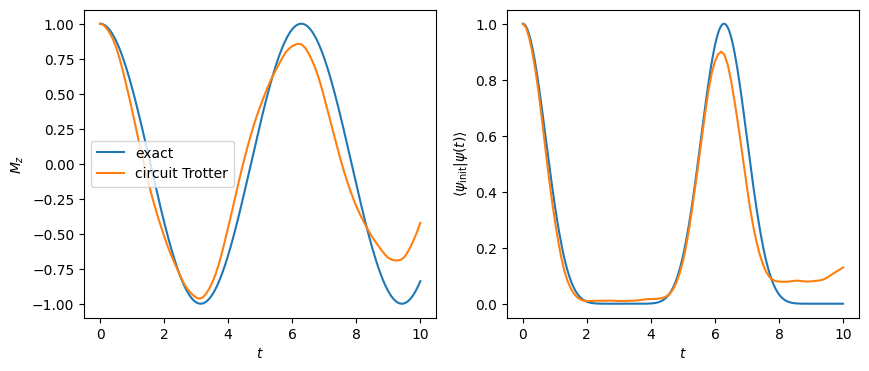

In [225]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axs[0].plot(t_eval, exact_mag, label="exact")
axs[0].plot(t_eval_trotter, trotter_circ_mag, label="circuit Trotter")
axs[0].set_xlabel(rf"$t$")
axs[0].set_ylabel(rf"$M_z$")

axs[1].plot(t_eval, init_state_revival)
axs[1].plot(t_eval_trotter, trotter_circ_init_state_rev)
axs[1].set_xlabel(rf"$t$")
axs[1].set_ylabel(rf"$\langle \psi_{{\rm init}} | \psi(t) \rangle$")

axs[0].legend()

plt.show()